# 기본 개념
## 1. Encoding & Decoding
인공지능 모델에는 0과 1의 비트로 표현 가능한 숫자 매트릭스만 입력할 수 있다. 따라서 텍스트 데이터를 입력하려면 단어에 숫자를 맵핑한 단어 사전을 만들고, 단어에서 숫자로 encode, 숫자에서 단어로 decode할 수 있도록 만들주어야 한다. 아래 예제에서는 'i feel hungry', 'i eat lunch', 'now i feel happy'라는 3개의 간단한 문장의 단어들을 숫자로 표현하는 예시를 들었다.

In [1]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

In [2]:
# 딕셔너리로 단어 사전 만들기
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다.
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다.
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)   # {인덱스:단어} 구조의 딕셔너리

In [3]:
# 딕셔너리를 {단어:인덱스} 구조로 바꾸기
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

In [5]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']가 아래와 같이 변환됩니다.
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

In [6]:
# 반대로, 숫자 벡터로 encode된 문장을 원래 텍스트로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  # [1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

In [7]:
# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

## 2. Embedding 레이어
단순히 텍스트를 숫자로 바꾼 데이터는 인공지능 모델의 입력으로 사용하기엔 어딘가 부족하다. 단어의 의미를 나타내는 벡터를 만들어 훈련 가능한 파라미터로 놓고 이를 딥러닝을 통해 학습해서 최적화할 수 있어야 한다. 이러한 의미벡터 파라미터를 구현한 것을 Embedding 레이어라고 한다. 이제 Lookup Table형태로 구성된 Embedding 레이어를 활용하여 이전 스텝의 텍스트 데이터를 워드벡터 텐서 형태로 다시 표현해볼 것이다. 이때 유의할 점은, Embedding 레이어의 인풋이 되는 문장 벡터의 길이가 일정해야 한다는 것이다. 문장 벡터 뒤에 0으로 된 패딩을 추가하여 길이를 맞춰주어야 한다.

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 4차원의 워드벡터를 가정 (변경 가능)

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# padding으로 word vector의 길이 맞추기
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)   # shape에서 3은 입력문장 개수, 5는 입력문장의 최대 길이, 4는 워드벡터의 차원수를 의미

tf.Tensor(
[[[ 0.00020378  0.04945518 -0.00241227 -0.04970206]
  [-0.01249854  0.0344717  -0.02991942 -0.03701938]
  [ 0.01386991 -0.00677185 -0.04424417  0.00175039]
  [ 0.00109487 -0.02515228 -0.0207739   0.02250204]
  [ 0.01643622 -0.00020786 -0.0480121  -0.04729075]]

 [[ 0.00020378  0.04945518 -0.00241227 -0.04970206]
  [-0.01249854  0.0344717  -0.02991942 -0.03701938]
  [ 0.01784482  0.0177759  -0.04394634 -0.01088767]
  [-0.00737165  0.01219853  0.01969201 -0.02328545]
  [ 0.01643622 -0.00020786 -0.0480121  -0.04729075]]

 [[ 0.00020378  0.04945518 -0.00241227 -0.04970206]
  [-0.01099447 -0.00561415 -0.01435689 -0.01650896]
  [-0.01249854  0.0344717  -0.02991942 -0.03701938]
  [ 0.01386991 -0.00677185 -0.04424417  0.00175039]
  [-0.00969218 -0.011184   -0.04079904  0.04317199]]], shape=(3, 5, 4), dtype=float32)


## 3. 딥러닝 모델
### 3-1. RNN
Recurrent Neural Netowrk(RNN)은 텍스트 데이터를 다루는데 주로 사용되는 딥러닝 모델이다. RNN은 시퀀스(Sequence) 형태의 데이터 처리에 최적인 모델로, 이전 시점의 모든 입력의 정보가 현재 상태에 반영되는 state machine으로 설계되었다.

In [9]:
vocab_size = 10  # 어휘 사전의 크기(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수

# 가장 널리 쓰이는 RNN인 LSTM 레이어로 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # LSTM state 벡터의 차원수 (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


### 3-2. CNN
텍스트 처리에 1-D Convolutional Neural Network(1-D CNN)을 사용할 수도 있다. 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식이다. GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 있으며, 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이다. CNN 계열 모델은 RNN 계열 모델보다 병렬처리가 효율적이기 때문에 학습속도가 훨씬 빠르다.

In [10]:
vocab_size = 10  # 어휘 사전의 크기(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수

# 1-D CNN 모델 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
vocab_size = 10  # 어휘 사전의 크기(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수

# GlobalMaxPooling1D() 레이어 하나만 사용
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


이 외에도 1-D CNN과 RNN 레이어를 섞어 쓰거나, FFN(FeedForward Network) 레이어만으로 구성하거나, 혹은 최근 각광받고 있는 Transformer 레이어 등 다양한 방법으로 모델을 구성할 수 있다.
***

# IMDB 영화리뷰 감성분석
## 1. IMDB 데이터셋 분석
### 1-1. 데이터 준비 및 확인
IMDB Large Movie Dataset은 50000개의 영화 리뷰 텍스트로 구성되어 있으며, 긍정은 1, 부정은 0의 라벨이 달려 있다. 50000개의 리뷰를 반으로 나눠 훈련용 데이터와 테스트용 데이터를 각각 25000개씩 사용하도록 지정되어 있다. IMDB 데이터셋은 이미 숫자로 encode된 데이터이므로 encode에 사용한 딕셔너리까지 함께 제공한다.

In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDB 데이터셋 다운로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)  # 단어사전에 등재할 단어 개수 지정
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.2.0
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [13]:
# 데이터 확인
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


### 1-2. 단어사전 확인 및 가공
word_to_index는 단어 출현 빈도를 기준으로 내림차순으로 정렬되어 있다. 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3개씩 뒤로 밀려있어 보정이 필요하다.

In [14]:
# 단어사전 확인
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])      # 'the' 가 출력됩니다.
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [15]:
# index를 3씩 뒤로 밀기
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 4개 인덱스는 사전에 정의된 것으로 추가
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

# 변경된 인덱스 확인
print(index_to_word[1])      # '<BOS>' 가 출력됩니다.
print(word_to_index['the'])  # 4 가 출력됩니다.
print(index_to_word[4])      # 'the' 가 출력됩니다.

<BOS>
4
the


In [16]:
# decode한 문장과 라벨을 비교하여 일치하는지 확인
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

### 1-3. 모델 구성을 위한 데이터 분석 및 가공
데이터를 모델에 입력하려면 pad_sequences를 통해 문장의 길이를 통일해주어야 한다. 이때 문장 최대 길이 maxlen의 값이 전체 모델 성능에 영향을 미치기 때문에, 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다. 그리고 padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다. RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다. 따라서 마지막 입력이 무의미한 padding으로 채워지는 'post'에 비해 'pre' 방식이 10% 이상 좋은 테스트 성능을 보인다.

In [17]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예시) 최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
# padding으로 문장 길이 맞추기
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                       value=word_to_index["<PAD>"],
                                       padding='post', # 혹은 'pre'
                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post', # 혹은 'pre'
                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## 2. 딥러닝 모델 설계와 훈련
### 2-1. 모델 설계

In [19]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 훈련용 데이터셋 25000건 중 10000건을 분리하여 validation set으로 사용
x_val = x_train[:10000]  
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건은 train set
partial_x_train = x_train[10000:] 
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


### 2-2. 모델 훈련

In [21]:
# model 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
30/30 [==============================] - 2s 58ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6929 - val_accuracy: 0.5055
Epoch 2/10
30/30 [==============================] - 1s 45ms/step - loss: 0.6928 - accuracy: 0.5097 - val_loss: 0.6929 - val_accuracy: 0.5015
Epoch 3/10
30/30 [==============================] - 1s 38ms/step - loss: 0.6917 - accuracy: 0.5097 - val_loss: 0.6922 - val_accuracy: 0.5016
Epoch 4/10
30/30 [==============================] - 1s 36ms/step - loss: 0.6877 - accuracy: 0.5150 - val_loss: 0.6914 - val_accuracy: 0.5082
Epoch 5/10
30/30 [==============================] - 1s 36ms/step - loss: 0.6823 - accuracy: 0.5358 - val_loss: 0.6898 - val_accuracy: 0.5086
Epoch 6/10
30/30 [==============================] - 1s 36ms/step - loss: 0.6790 - accuracy: 0.5285 - val_loss: 0.6897 - val_accuracy: 0.5063
Epoch 7/10
30/30 [==============================] - 1s 39ms/step - loss: 0.6754 - accuracy: 0.5309 - val_loss: 0.6893 - val_accuracy: 0.5081
Epoch 8/10
30

In [22]:
# test set으로 model 평가
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

782/782 - 5s - loss: 0.6935 - accuracy: 0.5153
[0.6935115456581116, 0.5153200030326843]


### 2-3. Loss, Accuracy 그래프 시각화
앞선 model.fit() 과정에서 train/validation loss, accuracy 등의 값이 매 epoch마다 history 변수에 저장된다. 이 데이터를 그래프로 그려보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있다.

In [23]:
# history 변수에 저장된 항목 확인
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


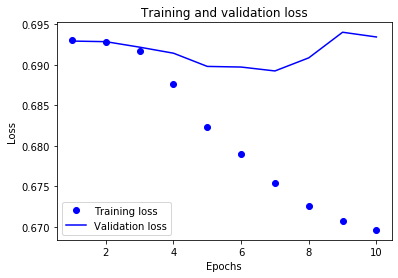

In [24]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')  # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 3. Word2Vec의 적용
### 3-1. 학습된 Embedding 레이어 분석
단어의 특성을 저차원 벡터값으로 표현하는 워드 임베딩(word embedding) 기법은 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법이다. 앞서 훈련 단계에서 사용했던 model의 첫번째 레이어 역시 Embedding 레이어였다. Embedding 레이어에 학습된 워드 벡터가 유의미하게 잘 학습되었는지 확인해본다.

In [25]:
# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.05793155,  0.00795009,  0.02432142,  0.00115768, -0.03043961,
        0.02092083, -0.03100175, -0.03629588, -0.00960938, -0.03866996,
        0.00562813, -0.04734397,  0.0231584 , -0.03359229,  0.03572191,
       -0.00967905], dtype=float32)

In [28]:
# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("love")  # 학습이 잘 되지 않아 별로 유사하지 않음

[('fantastic', 0.8723728060722351),
 ('appeal', 0.8453997373580933),
 ('bogart', 0.8384788632392883),
 ('douglas', 0.8352924585342407),
 ('psychiatrist', 0.8317170143127441),
 ('butcher', 0.8286617994308472),
 ('situations', 0.8281365036964417),
 ('harsh', 0.8276877403259277),
 ('carrie', 0.810916543006897),
 ('invisible', 0.8082454204559326)]

### 3-2. Word2Vec 임베딩 활용하여 성능 개선
구글은 Word2Vec이라는 사전학습된(Pretrained) 워드 임베딩 모델을 제공하고 있다. Word2Vec은 무려 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습된 모델이다. 총 300만 개의 단어가 각각 300차원의 벡터로 표현되어 있다. 이처럼 사전에 학습된 임베딩 모델을 활용하는 것을 전이학습(Transfer Learning)이라고 한다. 광범위한 데이터를 통해 미리 학습해 놓은 정보를 본인이 만들고자 하는 모델의 피처로 활용하면 훨씬 빠르고 정확하게 학습할 수 있다. 이제 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것이다.

In [29]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000) # 메모리가 많이 소모되므로 가장 많이 사용되는 상위 100만개로 limit
vector = word2vec['computer']
vector     # 300dim의 워드 벡터

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [30]:
# 유사한 단어와 그 유사도 확인
word2vec.similar_by_word("love")  # 학습이 잘 되어 유사함

[('loved', 0.6907792091369629),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100709438323975),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [31]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [32]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [33]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 19s 620ms/step - loss: 0.6932 - accuracy: 0.5474 - val_loss: 0.6716 - val_accuracy: 0.6031
Epoch 2/20
30/30 [==============================] - 8s 274ms/step - loss: 0.6393 - accuracy: 0.6591 - val_loss: 0.6085 - val_accuracy: 0.6905
Epoch 3/20
30/30 [==============================] - 8s 276ms/step - loss: 0.5101 - accuracy: 0.7747 - val_loss: 0.4293 - val_accuracy: 0.8152
Epoch 4/20
30/30 [==============================] - 8s 283ms/step - loss: 0.3364 - accuracy: 0.8618 - val_loss: 0.3336 - val_accuracy: 0.8583
Epoch 5/20
30/30 [==============================] - 8s 281ms/step - loss: 0.2365 - accuracy: 0.9103 - val_loss: 0.3050 - val_accuracy: 0.8723
Epoch 6/20
30/30 [==============================] - 8s 276ms/step - loss: 0.1697 - accuracy: 0.9452 - val_loss: 0.3054 - val_accuracy: 0.8735
Epoch 7/20
30/30 [==============================] - 8s 280ms/step - loss: 0.1290 - accuracy: 0.9622 - val_loss: 0.3304 - val_accuracy: 0.8653
Epoch

In [34]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)   # 정확도가 0.86으로 개선됨

782/782 - 9s - loss: 0.5239 - accuracy: 0.8604
[0.5238618850708008, 0.8604000210762024]
